# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [8]:
!pip install python_environment_check


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement python_environment_check (from versions: none)
ERROR: No matching distribution found for python_environment_check


In [7]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
}
check_packages(d)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement python_environment_check (from versions: none)
ERROR: No matching distribution found for python_environment_check


ModuleNotFoundError: ignored

In [9]:
from IPython.display import Image
%matplotlib inline

# Modeling complex functions with artificial neural networks

...

## Single-layer neural network recap

In [10]:
Image(filename='figures/11_01.png', width=600) 

FileNotFoundError: ignored

<br>
<br>

## Introducing the multi-layer neural network architecture

In [ ]:
Image(filename='figures/11_02.png', width=600) 

In [ ]:
Image(filename='figures/11_03.png', width=500) 

<br>
<br>

## Activating a neural network via forward propagation

<br>
<br>

# Classifying handwritten digits

...

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [2]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [3]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

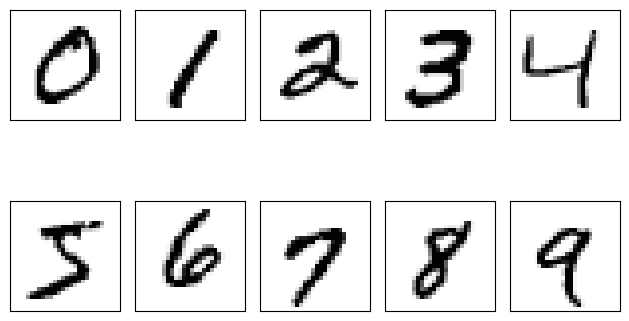

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

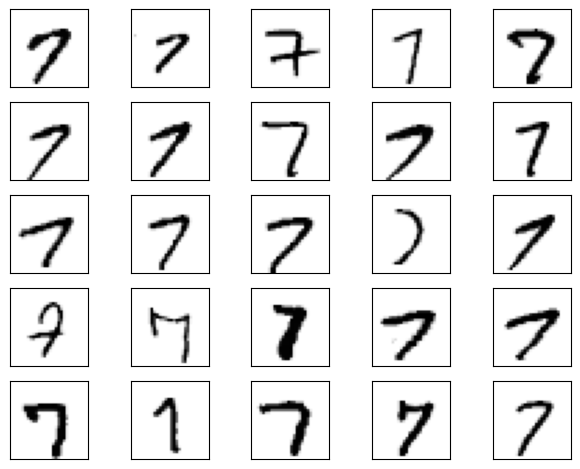

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [6]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

## Implementing a multi-layer perceptron


In [7]:
import numpy as np

class NeuralNetMLPSingle:
    def __init__(self, n_hidden, l2, epochs, eta):
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta

    def forward(self, X):
        # Compute activations of hidden layer
        z_h = np.dot(X, self.weight_h) + self.bias_h
        a_h = self._sigmoid(z_h)

        # Compute activations of output layer
        z_out = np.dot(a_h, self.weight_out) + self.bias_out
        a_out = self._softmax(z_out)

        return a_h, a_out

    def backward(self, X, a_h, a_out, y):
        # Output layer gradients
        grad_out = a_out - self._onehot_encoding(y)

        # Hidden layer gradients
        grad_h = np.dot(grad_out, self.weight_out.T) * self._sigmoid_derivative(a_h)

        # Weight gradients
        d_loss__d_w_out = np.dot(a_h.T, grad_out)
        d_loss__d_b_out = np.sum(grad_out, axis=0)
        d_loss__d_w_h = np.dot(X.T, grad_h)
        d_loss__d_b_h = np.sum(grad_h, axis=0)

        # Add L2 regularization to weight gradients
        d_loss__d_w_out += self.l2 * self.weight_out
        d_loss__d_w_h += self.l2 * self.weight_h

        return d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h

    def fit(self, X, y):
        # Initialize weights and biases
        self.weight_h = np.random.uniform(-1, 1, size=(X.shape[1], self.n_hidden))
        self.bias_h = np.zeros(self.n_hidden)
        self.weight_out = np.random.uniform(-1, 1, size=(self.n_hidden, np.unique(y).shape[0]))
        self.bias_out = np.zeros(np.unique(y).shape[0])

        # Convert class labels to integers if necessary
        if y.dtype == object:
            y = self._label_encoder(y)

        # One-hot encode the target variable
        y_enc = self._onehot_encoding(y)

        # Iterate over epochs
        for _ in range(self.epochs):
            a_h, a_out = self.forward(X)
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = self.backward(X, a_h, a_out, y)

            # Update weights and biases
            self.weight_h -= self.eta * d_loss__d_w_h
            self.bias_h -= self.eta * d_loss__d_b_h
            self.weight_out -= self.eta * d_loss__d_w_out
            self.bias_out -= self.eta * d_loss__d_b_out

    def predict(self, X):
        a_h, a_out = self.forward(X)
        return np.argmax(a_out, axis=1)

    def _sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _sigmoid_derivative(self, a):
        return a * (1 - a)

    def _onehot_encoding(self, y):
        return np.eye(np.unique(y).shape[0])[y]

    def _label_encoder(self, y):
        classes = np.unique(y)
        mapping = {label: idx for idx, label in enumerate(classes)}
        return np.array([mapping[label] for label in y])


def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_losses = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for epoch in range(num_epochs):
        model.fit(X_train, y_train)

        # Compute training loss and accuracy
        train_loss, train_acc = compute_mse_and_acc(model, X_train, y_train)
        epoch_losses.append(train_loss)
        epoch_train_acc.append(train_acc)

        # Compute validation accuracy
        _, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        epoch_valid_acc.append(valid_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f} | Valid Acc: {valid_acc:.2f}")

    return epoch_losses, epoch_train_acc, epoch_valid_acc


def compute_mse_and_acc(model, X, y):
    y_pred = model.predict(X)
    mse = mse_loss(y, y_pred)
    acc = accuracy(y, y_pred)
    return mse, acc


def mse_loss(targets, predicted_labels):
    return np.mean((targets - predicted_labels) ** 2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


In [8]:
# Train the model with single hidden layer
num_epochs = 50
learning_rate = 0.1

model_single = NeuralNetMLPSingle(n_hidden=100, l2=0.1, epochs=num_epochs, eta=learning_rate)
losses_single, train_acc_single, valid_acc_single = train(model_single, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate)

# Evaluate on the test set
test_mse_single, test_acc_single = compute_mse_and_acc(model_single, X_test, y_test)

print(f"Single Hidden Layer Model:")
print(f"Test Accuracy: {test_acc_single*100:.2f}%")
print(f'Initial valid MSE: {test_mse_single:.1f}')


Epoch 1/50 | Train Loss: 20.27 | Train Acc: 0.11 | Valid Acc: 0.11
Epoch 2/50 | Train Loss: 8.56 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 3/50 | Train Loss: 20.27 | Train Acc: 0.11 | Valid Acc: 0.11
Epoch 4/50 | Train Loss: 20.27 | Train Acc: 0.11 | Valid Acc: 0.11
Epoch 5/50 | Train Loss: 20.27 | Train Acc: 0.11 | Valid Acc: 0.11
Epoch 6/50 | Train Loss: 20.27 | Train Acc: 0.11 | Valid Acc: 0.11
Epoch 7/50 | Train Loss: 20.94 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 8/50 | Train Loss: 29.03 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 9/50 | Train Loss: 14.37 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 10/50 | Train Loss: 8.56 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 11/50 | Train Loss: 20.94 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 12/50 | Train Loss: 20.27 | Train Acc: 0.11 | Valid Acc: 0.11
Epoch 13/50 | Train Loss: 10.75 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 14/50 | Train Loss: 20.27 | Train Acc: 0.11 | Valid Acc: 0.11
Epoch 15/50 | Train Loss: 20.27 | Train Acc: 0.11 | Valid A

## Implementing a multi-layer perceptron and multy hiden layer ANN




In [16]:
import numpy as np

In [27]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden layers
        rng = np.random.RandomState(random_seed)
        
        self.weight_h1 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)
        
        self.weight_h2 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)
        
        # output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer 1
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer 2
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):
        # Output layer weights gradients
        y_onehot = int_to_onehot(y, self.num_classes)
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        d_z_out__dw_out = a_h2
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        # Hidden layer 2 weights gradients
        d_z_out__a_h2 = self.weight_out
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)
        d_z_h2__dw_h2 = a_h1
        d_loss__dw_h2 = np.dot((d_loss__a_h2 * d_a_h2__d_z_h2).T, d_z_h2__dw_h2)
        d_loss__db_h2 = np.sum(d_loss__a_h2 * d_a_h2__d_z_h2, axis=0)

        # Hidden layer 1 weights gradients
        d_z_h2__a_h1 = self.weight_h2
        d_loss__a_h1 = np.dot(d_loss__a_h2 * d_a_h2__d_z_h2, d_z_h2__a_h1)
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)
        d_z_h1__dw_h1 = x
        d_loss__dw_h1 = np.dot((d_loss__a_h1 * d_a_h1__d_z_h1).T, d_z_h1__dw_h1)
        d_loss__db_h1 = np.sum(d_loss__a_h1 * d_a_h1__d_z_h1, axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__dw_h2, d_loss__db_h2,
                d_loss__dw_h1, d_loss__db_h1)
        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [28]:

# Define the model with two hidden layers
model = NeuralNetMLP(num_features=28*28, num_hidden1=50, num_hidden2=50, num_classes=10)


## fully connected ANN implemented using Keras

In [56]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Convert target labels to categorical format
y_train_categorical = to_categorical(y_train)
y_valid_categorical = to_categorical(y_valid)

# Define the model architecture
model_keras = Sequential()
model_keras.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
model_keras.add(Dense(units=10, activation='softmax'))

# Compile the model
model_keras.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model_keras.fit(X_train, y_train_categorical, epochs=num_epochs, batch_size=minibatch_size, validation_data=(X_valid, y_valid_categorical))

# Evaluate on the test set
y_test_categorical = to_categorical(y_test)
test_loss_keras, test_acc_keras = model_keras.evaluate(X_test, y_test_categorical, verbose=0)

print(f"Keras Fully Connected ANN:")
print(f"Test Accuracy: {test_acc_keras*100:.2f}%")


Epoch 1/50
550/550 [==============================] - 4s 6ms/step - loss: 0.3845 - accuracy: 0.8826 - val_loss: 0.2461 - val_accuracy: 0.9300
Epoch 2/50
550/550 [==============================] - 4s 7ms/step - loss: 0.2001 - accuracy: 0.9408 - val_loss: 0.1793 - val_accuracy: 0.9508
Epoch 3/50
550/550 [==============================] - 2s 4ms/step - loss: 0.1519 - accuracy: 0.9543 - val_loss: 0.1495 - val_accuracy: 0.9584
Epoch 4/50
550/550 [==============================] - 2s 4ms/step - loss: 0.1252 - accuracy: 0.9622 - val_loss: 0.1480 - val_accuracy: 0.9572
Epoch 5/50
550/550 [==============================] - 2s 4ms/step - loss: 0.1027 - accuracy: 0.9696 - val_loss: 0.1451 - val_accuracy: 0.9600
Epoch 6/50
550/550 [==============================] - 3s 5ms/step - loss: 0.0913 - accuracy: 0.9720 - val_loss: 0.1228 - val_accuracy: 0.9648
Epoch 7/50
550/550 [==============================] - 2s 4ms/step - loss: 0.0833 - accuracy: 0.9741 - val_loss: 0.1206 - val_accuracy: 0.9658
Epoch 

## Coding the neural network training loop




Defining data loaders:

In [29]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [31]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


a_h1, a_h2, a_out = model.forward(X_valid)
mse = mse_loss(y_valid, a_out)

predicted_labels = np.argmax(a_out, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 9.0%


In [36]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        a_h1, a_h2, a_out = nnet.forward(features)
        predicted_labels = np.argmax(a_out, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - a_out)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [37]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.0%


In [46]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1 = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [47]:
np.random.seed(123) # for the training set shuffling

# Train the model
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=0.1)



Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 18.53% | Valid Acc: 18.50%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 28.39% | Valid Acc: 28.42%
Epoch: 003/050 | Train MSE: 0.07 | Train Acc: 43.50% | Valid Acc: 43.94%
Epoch: 004/050 | Train MSE: 0.06 | Train Acc: 63.36% | Valid Acc: 63.78%
Epoch: 005/050 | Train MSE: 0.05 | Train Acc: 72.16% | Valid Acc: 71.82%
Epoch: 006/050 | Train MSE: 0.04 | Train Acc: 83.30% | Valid Acc: 83.30%
Epoch: 007/050 | Train MSE: 0.03 | Train Acc: 86.24% | Valid Acc: 86.02%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 87.77% | Valid Acc: 87.74%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 88.78% | Valid Acc: 88.74%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 89.42% | Valid Acc: 89.46%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 89.96% | Valid Acc: 89.94%
Epoch: 012/050 | Train MSE: 0.02 | Train Acc: 90.39% | Valid Acc: 90.22%
Epoch: 013/050 | Train MSE: 0.02 | Train Acc: 90.74% | Valid Acc: 90.60%
Epoch: 014/050 | Train MSE: 0.02 | Train Acc: 91.21

## Evaluating the neural network performance

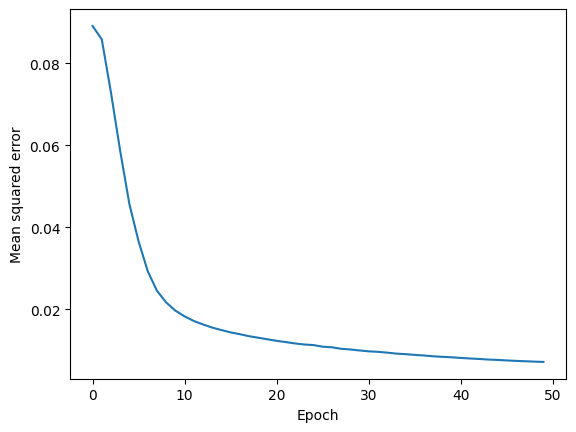

In [48]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

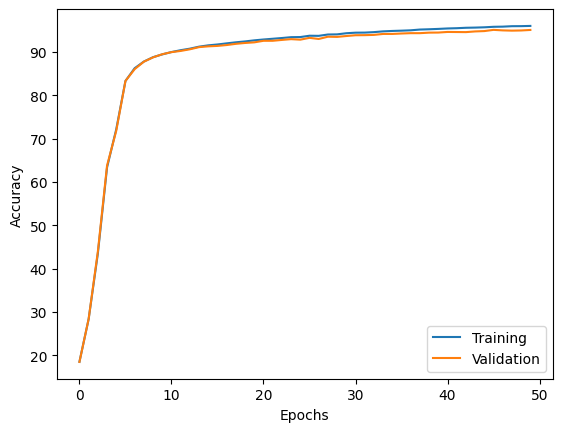

In [49]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [50]:
# Evaluate on test data
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
test_acc *= 100

print(f'Test MSE: {test_mse:.2f}')
print(f'Test Accuracy: {test_acc:.2f}%')

Test MSE: 0.01
Test Accuracy: 94.84%


Plot failure cases:

In [52]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

a_h1, a_h2, a_out  = model.forward(X_test_subset)
test_pred = np.argmax(a_out, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

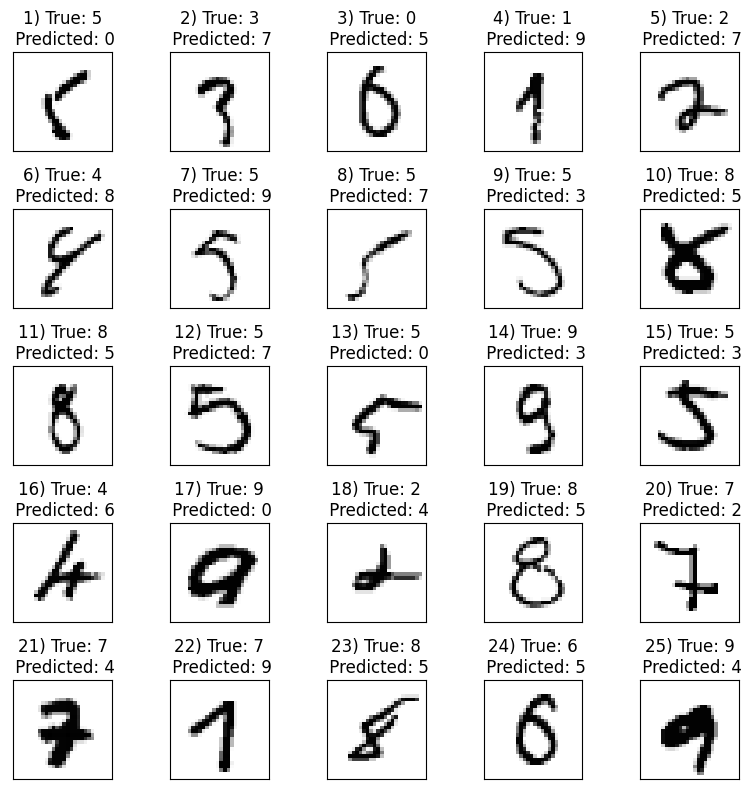

In [53]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

# Training an artificial neural network

...

## Computing the loss function

In [54]:
Image(filename='figures/11_10.png', width=300) 

FileNotFoundError: ignored

<br>
<br>

## Developing your intuition for backpropagation

...

## Training neural networks via backpropagation

In [ ]:
Image(filename='./figures/11_11.png', width=400) 

In [ ]:
Image(filename='figures/11_12.png', width=500) 

In [ ]:
Image(filename='figures/11_13.png', width=500) 

<br>
<br>

# Convergence in neural networks

In [ ]:
Image(filename='figures/11_14.png', width=500) 

<br>
<br>

...

# Summary

# ...

---

Readers may ignore the next cell.

In [ ]:
! python ../.convert_notebook_to_script.py --input ch11.ipynb --output ch11.py